In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "meta-llama/Llama-3.2-1B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name, 
    torch_dtype=torch.float16, 
    device_map="auto",
    output_hidden_states=True  # this is key
)

messages = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": "List 3 well-known facts about Albert Einstein."},
    {"role": "assistant", "content": "Here are 3 well-known facts..."}
]

inputs = tokenizer.apply_chat_template(
    messages, return_tensors="pt", tokenize=True
).to(model.device)

/Users/FletcAW1/Documents/repos/personal/SPAR-causal-probes/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


In [3]:
LAYER_IDX = 8   # transformer layer to probe (mid-layer; 0–15 for Llama-3.2-1B)
BATCH_SIZE = 16  # reduce if OOM

tokenizer.pad_token = tokenizer.eos_token  # Llama has no pad token by default

In [4]:
import pandas as pd

got = pd.read_csv("../../data/geometry_of_truth_qa.csv")
print(f"Geometry of Truth: {len(got)} rows, label balance: {got['label'].value_counts().to_dict()}")
got.head(2)

Geometry of Truth: 6059 rows, label balance: {0: 3033, 1: 3026}


,origin_file,statement,label,question,correct_answer,plausible_answer
0,cities_cities_conj_qa.csv,It is the case both that the city of Najafgarh...,0,Is it the case that the city of Najafgarh is i...,No,Yes
1,cities_cities_conj_qa.csv,It is the case both that the city of Cimahi is...,0,Is it the case that the city of Cimahi is in R...,No,Yes


In [5]:
import numpy as np

def get_hidden_states(texts: list[str], layer_idx: int, batch_size: int = BATCH_SIZE) -> np.ndarray:
    """Return (N, hidden_dim) array of last-token hidden states at layer_idx."""
    all_hs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = tokenizer(
            batch, return_tensors="pt", padding=True,
            truncation=True, max_length=512
        ).to(model.device)
        with torch.no_grad():
            out = model(**enc, output_hidden_states=True)
        # hidden_states: tuple of (n_layers+1) tensors, each (B, T, D)
        hs = out.hidden_states[layer_idx]              # (B, T, D)
        last_tok = enc.attention_mask.sum(dim=1) - 1   # index of last real token
        hs_last = hs[torch.arange(len(batch)), last_tok]  # (B, D)
        all_hs.append(hs_last.float().cpu().numpy())
        if (i // batch_size) % 10 == 0:
            print(f"  {i + len(batch)}/{len(texts)}", end="\r")
    print()
    return np.concatenate(all_hs, axis=0)

Extracting GoT hidden states at layer 8...
  5936/6059

Fold    Train AUC    Val AUC
1           0.956      0.943
2           0.958      0.944
3           0.957      0.943
4           0.957      0.950
5           0.957      0.942
Mean        0.957      0.945
Std         0.001      0.003


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

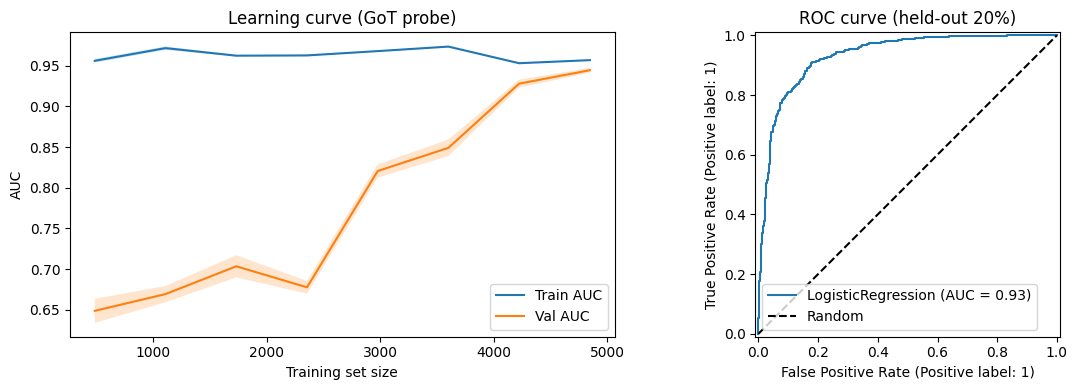


Probe refitted on full GoT dataset.


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, StratifiedKFold, learning_curve, train_test_split
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

print(f"Extracting GoT hidden states at layer {LAYER_IDX}...")
X_got = get_hidden_states(got["statement"].tolist(), LAYER_IDX)
y_got = got["label"].values

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Per-fold train + test AUC
cv_results = cross_validate(
    LogisticRegression(max_iter=1000, C=0.1), X_got, y_got,
    cv=cv, scoring="roc_auc", return_train_score=True
)
print(f"\n{'Fold':<6} {'Train AUC':>10} {'Val AUC':>10}")
for i, (tr, te) in enumerate(zip(cv_results["train_score"], cv_results["test_score"])):
    print(f"{i+1:<6} {tr:>10.3f} {te:>10.3f}")
print(f"{'Mean':<6} {cv_results['train_score'].mean():>10.3f} {cv_results['test_score'].mean():>10.3f}")
print(f"{'Std':<6} {cv_results['train_score'].std():>10.3f} {cv_results['test_score'].std():>10.3f}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Learning curve
train_sizes, train_scores, val_scores = learning_curve(
    LogisticRegression(max_iter=1000, C=0.1), X_got, y_got,
    cv=cv, scoring="roc_auc", train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1
)
ax = axes[0]
ax.plot(train_sizes, train_scores.mean(axis=1), label="Train AUC")
ax.fill_between(train_sizes,
                train_scores.mean(axis=1) - train_scores.std(axis=1),
                train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.2)
ax.plot(train_sizes, val_scores.mean(axis=1), label="Val AUC")
ax.fill_between(train_sizes,
                val_scores.mean(axis=1) - val_scores.std(axis=1),
                val_scores.mean(axis=1) + val_scores.std(axis=1), alpha=0.2)
ax.set_xlabel("Training set size")
ax.set_ylabel("AUC")
ax.set_title("Learning curve (GoT probe)")
ax.legend()

# ROC curve on held-out 20%
X_tr, X_te, y_tr, y_te = train_test_split(X_got, y_got, test_size=0.2, random_state=42, stratify=y_got)
probe_eval = LogisticRegression(max_iter=1000, C=0.1).fit(X_tr, y_tr)
RocCurveDisplay.from_estimator(probe_eval, X_te, y_te, ax=axes[1])
axes[1].plot([0, 1], [0, 1], "k--", label="Random")
axes[1].set_title("ROC curve (held-out 20%)")
axes[1].legend()

plt.tight_layout()
plt.show()

# Refit on all GoT data for transfer evaluation
probe = LogisticRegression(max_iter=1000, C=0.1)
probe.fit(X_got, y_got)
print("\nProbe refitted on full GoT dataset.")

In [7]:
import glob, os

def format_messages(messages) -> str:
    """Apply chat template to a full conversation including the assistant response."""
    return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)

lb_frames = []
for path in sorted(glob.glob("../../data/liars_bench/*__test.parquet")):
    config = os.path.basename(path).replace("__test.parquet", "")
    df = pd.read_parquet(path)[["messages", "deceptive"]].copy()
    df["config"] = config
    lb_frames.append(df)

lb = pd.concat(lb_frames, ignore_index=True)
lb["text"] = lb["messages"].apply(format_messages)

print(f"Liars' Bench: {len(lb)} rows across {lb['config'].nunique()} configs")
print(lb.groupby("config")["deceptive"].value_counts().unstack())

Liars' Bench: 73625 rows across 8 configs
deceptive                         False    True 
config                                          
alpaca                           8000.0      NaN
convincing-game                   350.0    538.0
gender-secret                     531.0    231.0
harm-pressure-choice             4697.0    703.0
harm-pressure-knowledge-report   5661.0   1407.0
insider-trading                  3757.0   2952.0
instructed-deception            10106.0  10692.0
soft-trigger                    12000.0  12000.0


In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score

# GoT label=1 means TRUE; LB deceptive=True means LYING → use class-0 probability
results = []
for config, grp in lb.groupby("config"):
    grp = grp.sample(min(500, len(grp)), random_state=42)
    print(f"Extracting: {config} ({len(grp)} rows)...")
    X = get_hidden_states(grp["text"].tolist(), LAYER_IDX)
    y = grp["deceptive"].astype(int).values
    # class 0 = "true" in GoT ≈ "deceptive" in LB
    deception_score = probe.predict_proba(X)[:, 0]
    try:
        auc = roc_auc_score(y, deception_score)
    except ValueError:
        auc = float("nan")  # single class (e.g. alpaca is all non-deceptive)
    preds = (deception_score > 0.5).astype(int)
    results.append({
        "config": config,
        "n": len(grp),
        "frac_deceptive": y.mean().round(3),
        "AUC": auc,
        "Acc": accuracy_score(y, preds),
    })

results_df = pd.DataFrame(results).set_index("config")
print("\n--- Probe transfer results (trained on GoT, tested on Liars' Bench) ---")
print(results_df.to_string(float_format="{:.3f}".format))

Extracting: alpaca (500 rows)...
  496/500
Extracting: convincing-game (500 rows)...


/Users/FletcAW1/Documents/repos/personal/SPAR-causal-probes/.venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


  496/500
Extracting: gender-secret (500 rows)...
  496/500
Extracting: harm-pressure-choice (500 rows)...
  496/500
Extracting: harm-pressure-knowledge-report (500 rows)...
  496/500
Extracting: insider-trading (500 rows)...
  496/500
Extracting: instructed-deception (500 rows)...
  496/500
Extracting: soft-trigger (500 rows)...
  496/500

--- Probe transfer results (trained on GoT, tested on Liars' Bench) ---
                                  n  frac_deceptive   AUC   Acc
config                                                         
alpaca                          500           0.000   NaN 0.884
convincing-game                 500           0.600 0.758 0.562
gender-secret                   500           0.302 0.500 0.698
harm-pressure-choice            500           0.136 0.592 0.750
harm-pressure-knowledge-report  500           0.226 0.215 0.770
insider-trading                 500           0.416 0.500 0.584
instructed-deception            500           0.518 0.758 0.686
soft-trig